# Lab 3

This week we look at a new dataset below.

In [ ]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/lab3.zip -o lab3.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50.7M  100 50.7M    0     0   148M      0 --:--:-- --:--:-- --:--:--  147M


In [ ]:
!unzip -q lab3.zip

The above commands should create a `train/` folder and `test/` folder in this directory. Each folder contains `images/` and `labels/` subdirectories respectively.

In this dataset, each image is associated with a text file. In the text file, each row represents a single bounding box around a person in the image. Each bounding box is represented by 5 numbers: x_center, y_center, width, height, objectness. Objectness is always 1. All other dimensions are represented as fractions of image dimensions. e.g. x_center's actual pixel location needs to be multiplied by the width of the image.

If you still recall the network you worked with in Lab 2:
```python
class FCN(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

backbone = ...
head = ...
model = FCN(backbone, head)
```

Here's an idea. Given that the backbone defined above will output a spatial feature map, we can iterate over each cell location in the spatial feature map, and predict if there is an object to detect in that cell (objectness). Notice that this is very similar to FCN segmentation where we were practically doing pixel-wise classification. However, we take this a bit further. If objectness in each cell is high enough, we predict an object within a bounding box as specified by our neural network.

## Another new network

Create a new class that is almost the exact same as `FCN` above, but specify the `head` to be a `nn.Conv2d` layer with kernel size 1. This layer should output 5 channels, corresponding to the 5 numbers in each row of our labels. This network will be architecturally simpler than the FCN of Lab 2!

_1 pt granted upon completion of network definition_

In [ ]:
# Your work here
import torch
from torch import nn
from torchvision.models import resnet34, ResNet34_Weights
class FCN(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
backbone = nn.Sequential(*list(resnet.children())[:-2])
head = nn.Sequential(nn.Conv2d(512, 5, kernel_size=1))
model = FCN(backbone, head)



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


## Dataset and dataloaders

Now go ahead and build your Dataset and Dataloaders in Pytorch.

Note that the dataset should calculate and return x_offset and y_offset instead of x_center and y_center. If you leave x_center and y_center as is, you will force your network to also learn how to predict larger values of x_center and y_center with increasing values of x and y on the spatial feature map output by the backbone! You can resolve this by storing the offset between the bounding box center and the center of the cell of the spatial feature map your bounding box is in. I'll help you a little by providing an example:

```python
ipdb>  grid_size
8

ipdb>  grid_y
4

ipdb>  grid_y_min
0.5

ipdb>  y_center
0.5132275132275133

ipdb>  y_offset
0.013227513227513255
```

_1 pt granted upon successfully running the code below_,

```python
train_dataset = ...
test_dataset = ...
train_dataloader = DataLoader(train_dataset, ...)
test_dataloader = DataLoader(test_dataset, ...)
one_X, one_y = next(iter(test_dataset))
batch_X, batch_y = next(iter(test_dataloader))
```

_and demonstrating the following results_:
- `one_X.shape` = (3, im_h, im_w) where im_h and im_w are height and width of the image
- `one_y.shape` = (5, gy, gx) where gy and gx are height and width of the spatial feature map
- `batch_X.shape` = (B, 3, im_h, im_w) where B is batch size
- `batch_y.shape` = (B, 5, gy, gx)

Unless you've went out of your way to resize your images to a shape other than a square, `im_h` should be equal to `im_w`, and `gy` should be equal to `gx`.

In [ ]:
# Your work here
import torch
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
from torchvision import transforms

class ResizedObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, label_dir, target_size=(256, 256), grid_size=(8, 8), transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.target_size = target_size  # (height, width)
        self.grid_size = grid_size  # (gridy, gridx)
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')

        # Read image and resize
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]

        # Resize the image to target_size
        image = cv2.resize(image, (self.target_size[1], self.target_size[0]))

        # Initialize target tensor
        gridy, gridx = self.grid_size
        target = torch.zeros(5, gridy, gridx)

        # Read bounding boxes from label file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                x_center, y_center, width, height, _ = map(float, line.strip().split())

                grid_x = int(x_center * gridx)
                grid_y = int(y_center * gridy)

                cell_x = x_center * gridx - grid_x
                cell_y = y_center * gridy - grid_y

                target[0, grid_y, grid_x] = cell_x  # x_offset
                target[1, grid_y, grid_x] = cell_y  # y_offset
                target[2, grid_y, grid_x] = width * gridx  # width
                target[3, grid_y, grid_x] = height * gridy  # height
                target[4, grid_y, grid_x] = 1.0  # objectness

        if self.transform:
            image = self.transform(image)


        return image, target

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import DataLoader

test_dataset = ResizedObjectDetectionDataset(
    image_dir='test/images',
    label_dir='test/labels',
    target_size=(256, 256),
    grid_size=(8, 8),
    transform=transform
)

train_dataset = ResizedObjectDetectionDataset(
    image_dir='train/images',
    label_dir='train/labels',
    target_size=(256, 256),
    grid_size=(8, 8),
    transform=transform
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
one_X, one_y = next(iter(test_dataset))
batch_X, batch_y = next(iter(test_dataloader))

In [ ]:
print(one_X.shape)
print(one_y.shape)
print(batch_X.shape)
print(batch_y.shape)

torch.Size([3, 256, 256])
torch.Size([5, 8, 8])
torch.Size([16, 3, 256, 256])
torch.Size([16, 5, 8, 8])


## Visualization

Being able to see is important for diagnosing computer vision applications. Create a visualization function to plot an overlay of bounding boxes on their respective images. You can use this function template below.

```python
def plot_batch_predictions(imgs, outputs):
    # img should have shape (batch, 3, im_h, im_w)
    # outputs should have shape (batch, 5, gy, gx)
    ...
```

Will also show you some sample matplotlib code to save time:

```python
import numpy as np
import matplotlib.pyplot as plt

# This creates a matplotlib figure with 4 cols
# Note that axes is an array of individual `ax`
batch_size = 4
fig, axes = plt.subplots(ncols=batch_size, figsize=(20, 8))
axes = axes if isinstance(axes, np.ndarray) else [axes]  # Handle batch_size=1

# This is how to plot an image
# Note that imshow requires image dimensions to be (H, W, 3)
# while Pytorch works with image dimensions (3, H, W)!
mock_tensor = torch.rand(3, 128, 128)
mock_np = mock_tensor.permute(1, 2, 0).contiguous().numpy()
# Usually you would just use plt.imshow where plt will grab the latest ax
# When you have as many as 4 in this example, specify which ax to use
ax = axes[0]
ax.imshow(img_np)
    
# This is how to draw rectangles using matplotlib
xmin = int((x_center - width / 2) * im_width)
xmax = int((x_center + width / 2) * im_width)
rect = plt.Rectangle(
    (xmin, ymin), width, height,
    linewidth=2, edgecolor='red', facecolor='none'
)
# Add the rectangle to the Axes
ax.add_patch(rect)
```

Remember that your network output is x_offset and y_offset, need to convert them back to x_center and y_center!

_1 pt granted upon plotting one batch of images and labels from `test_dataloader` using `plot_batch_predictions`_

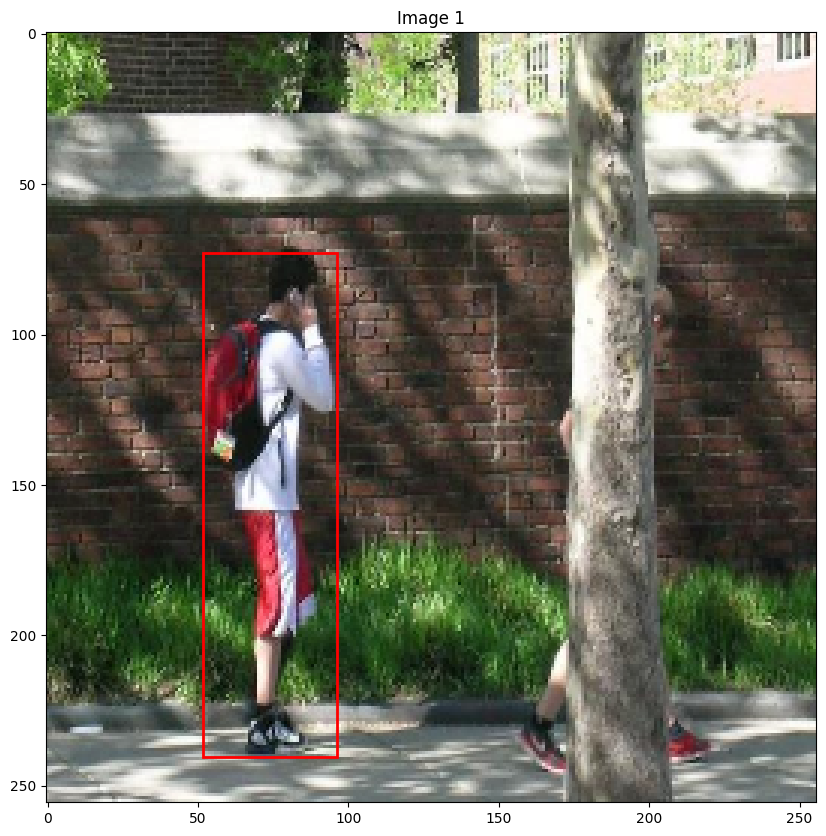

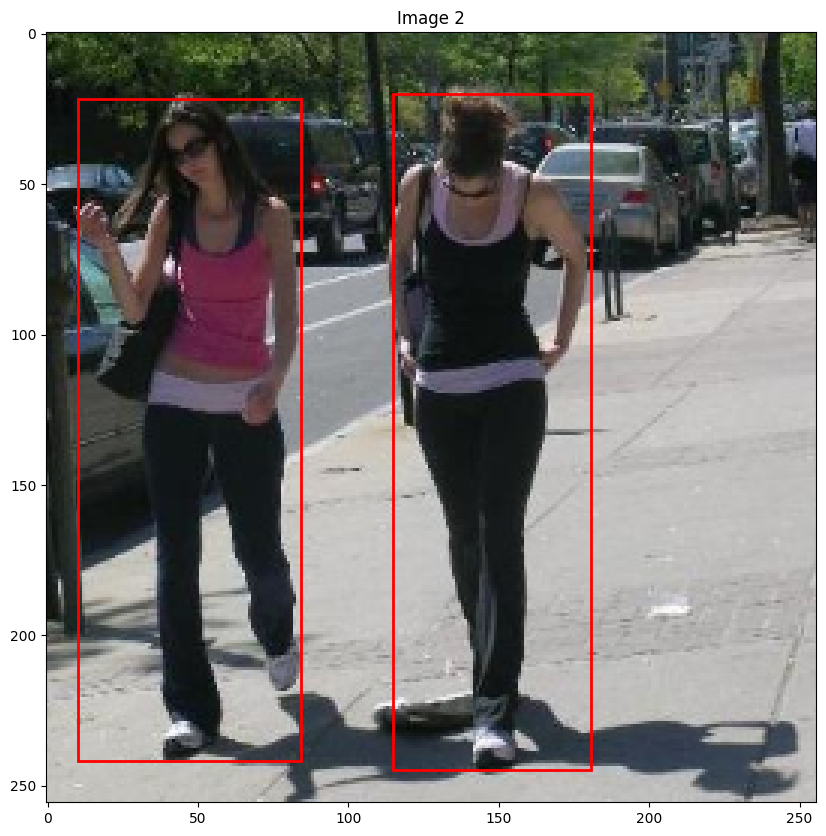

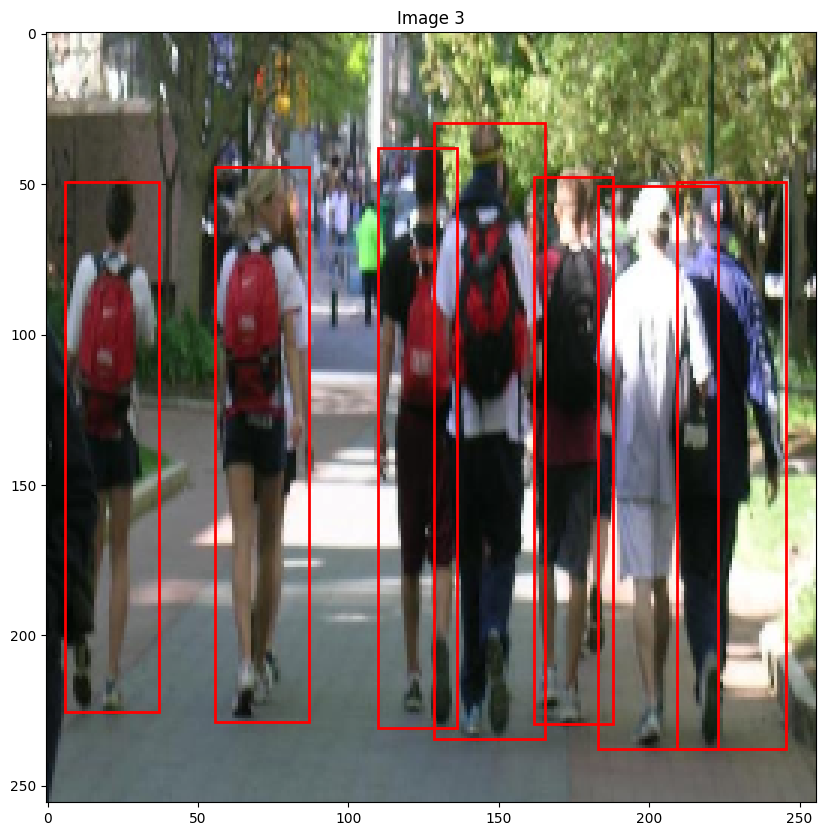

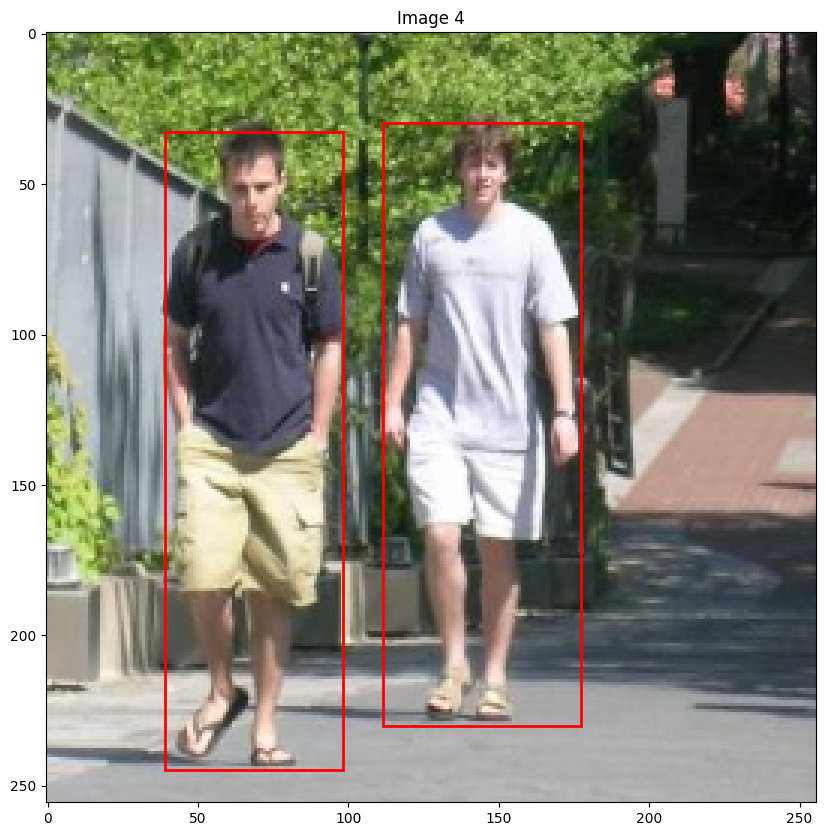

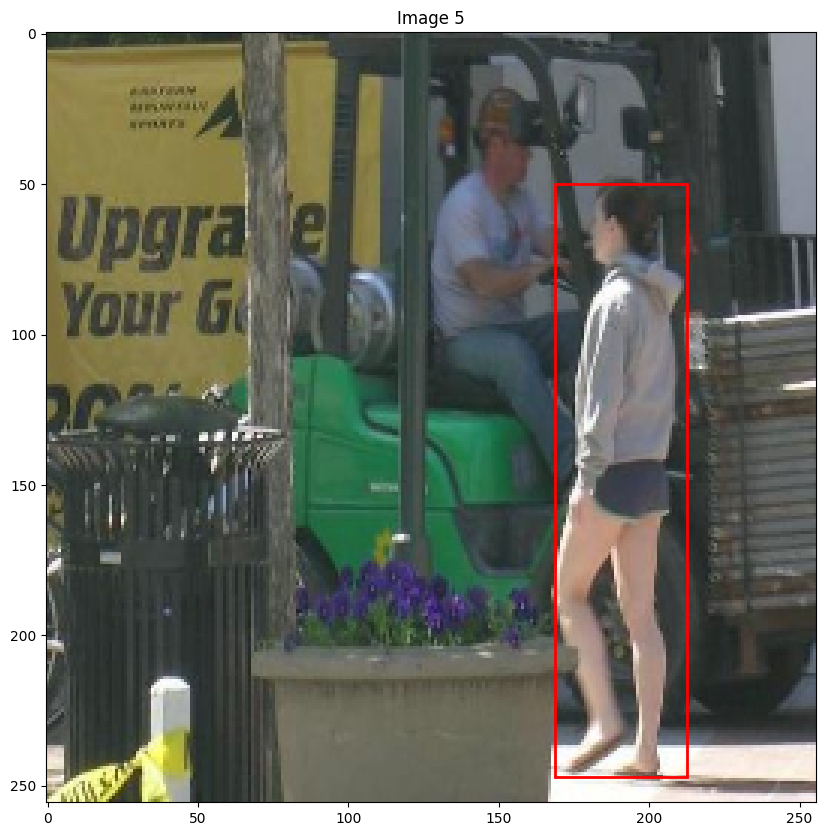

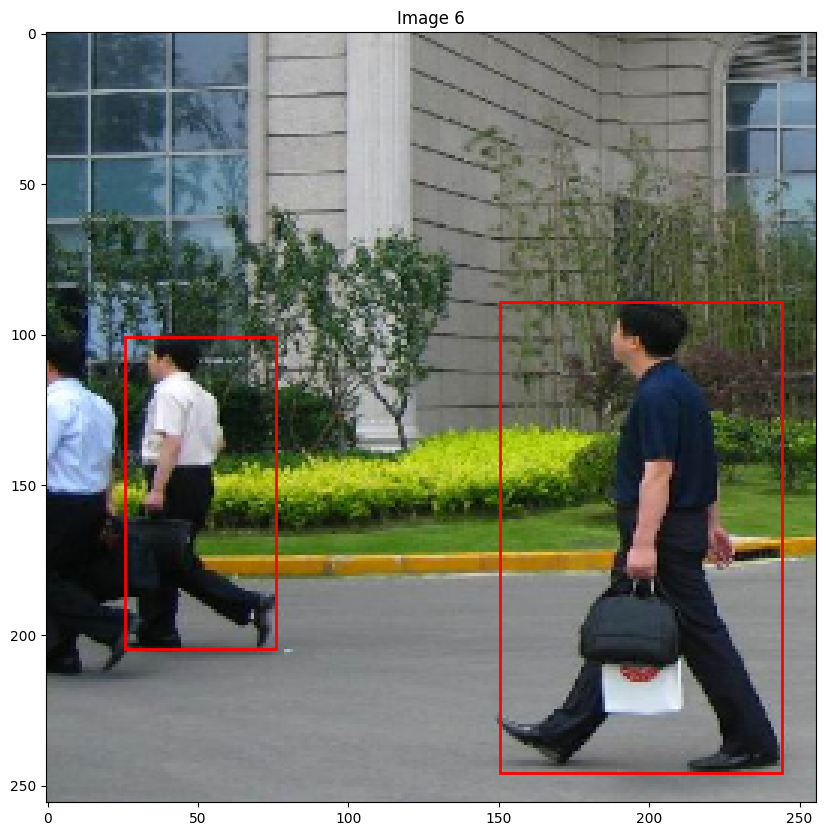

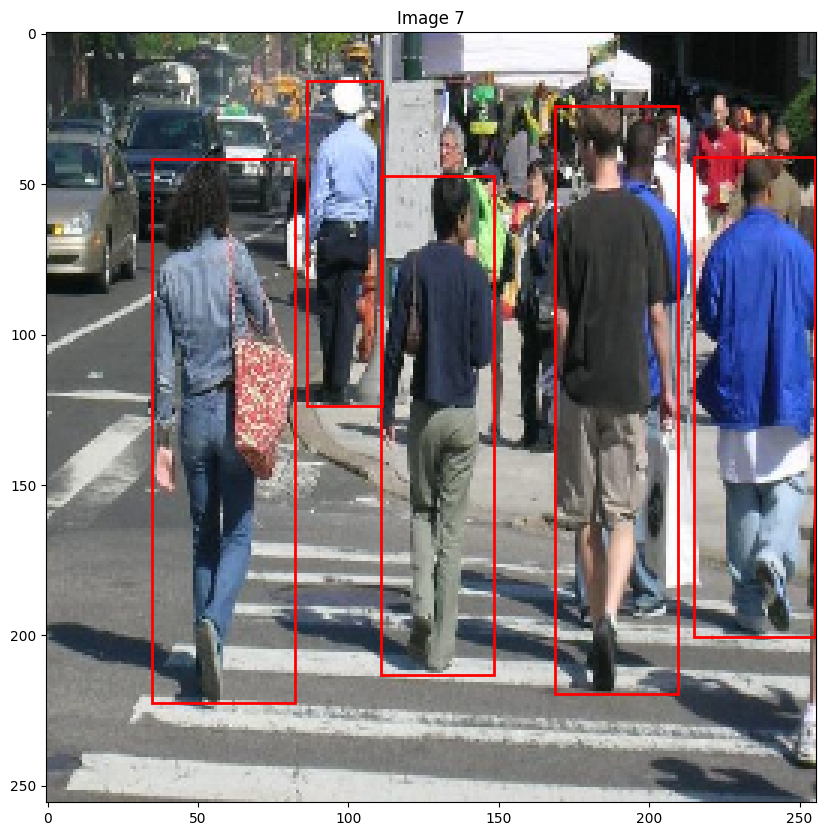

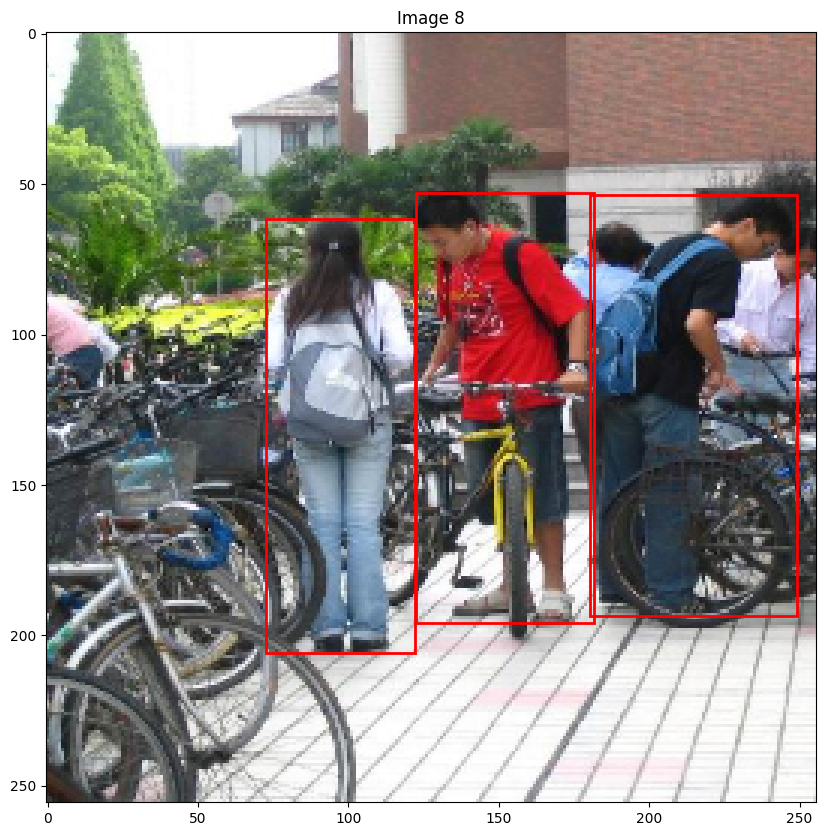

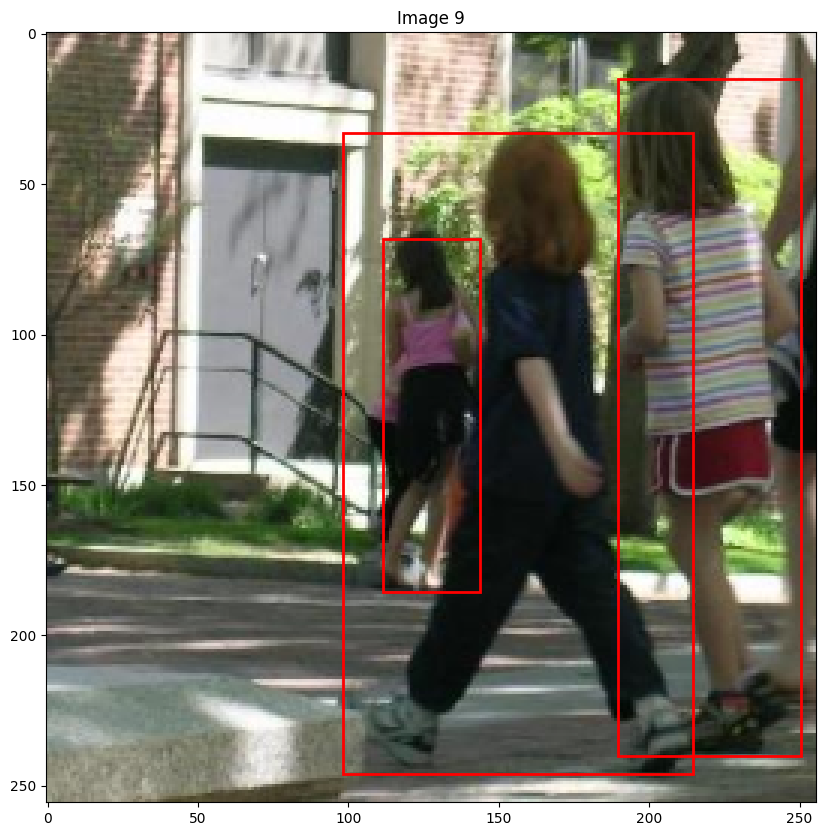

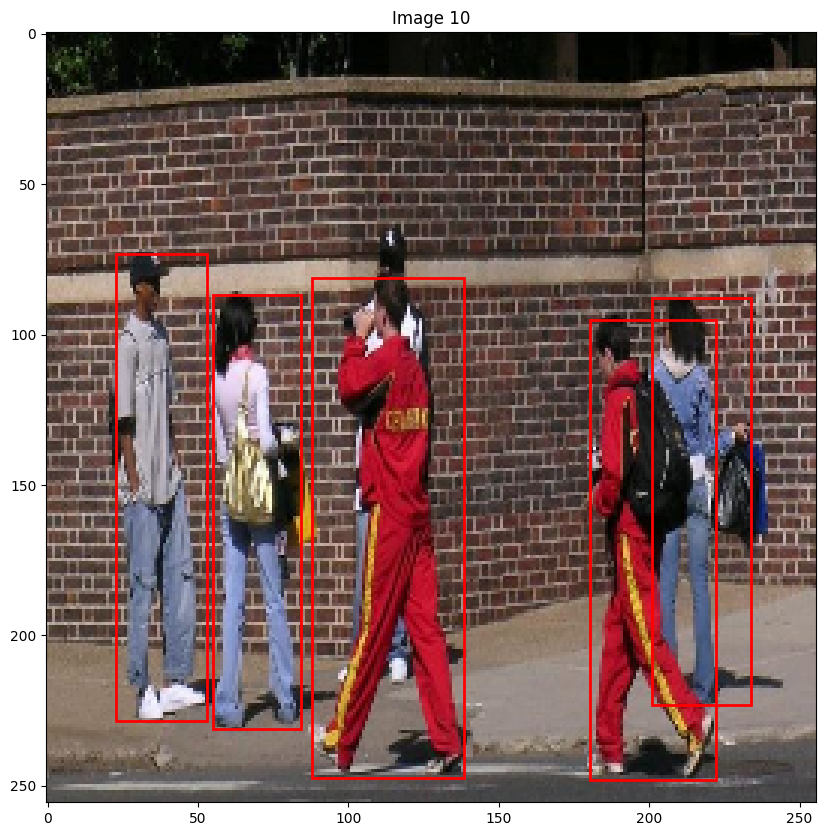

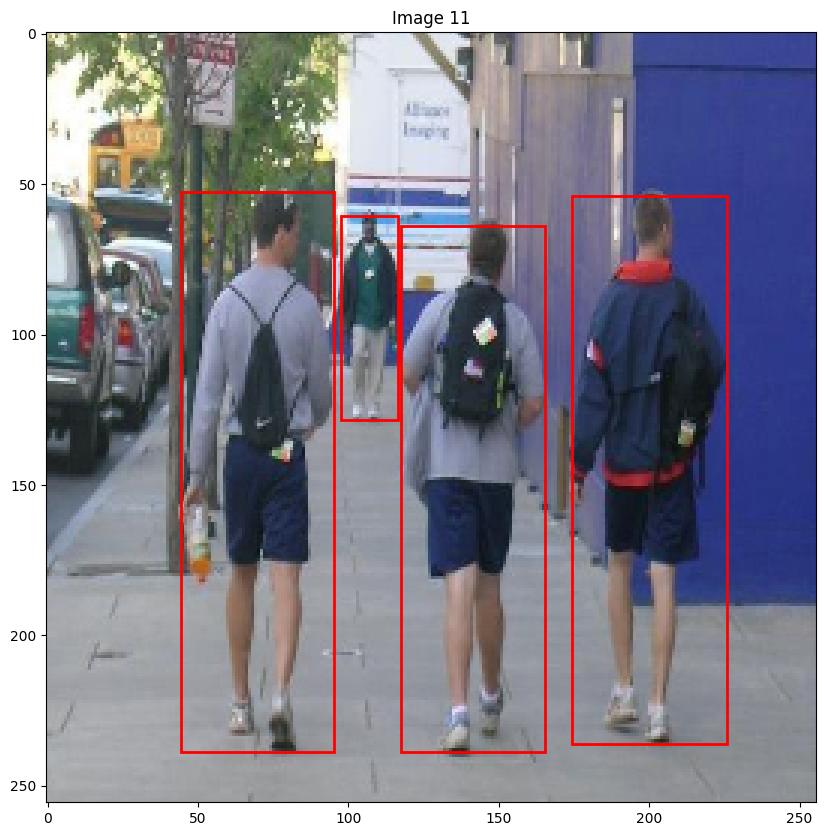

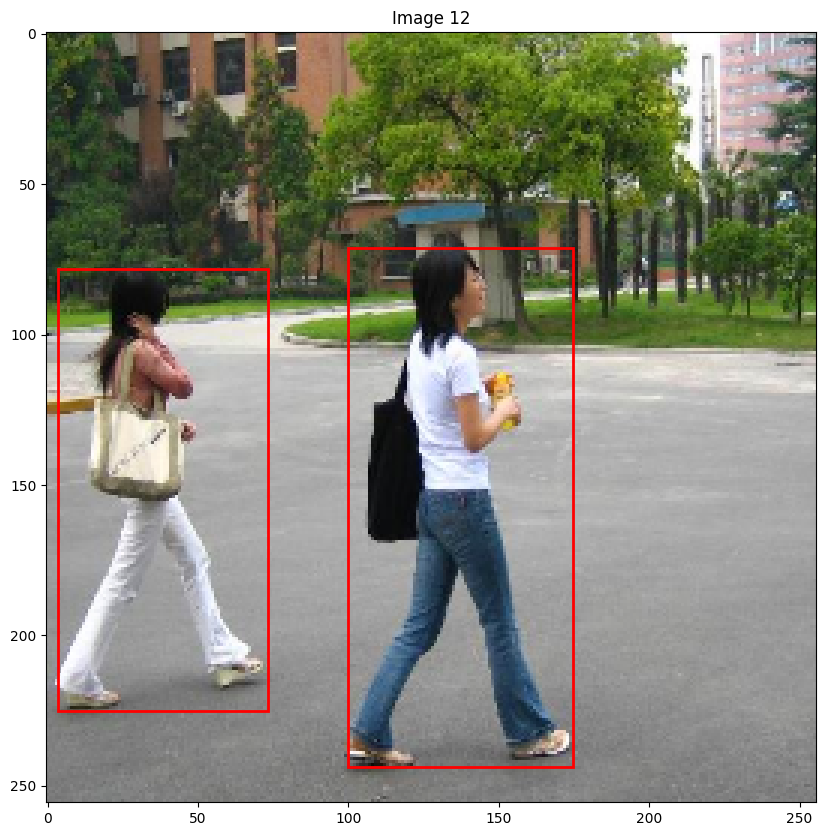

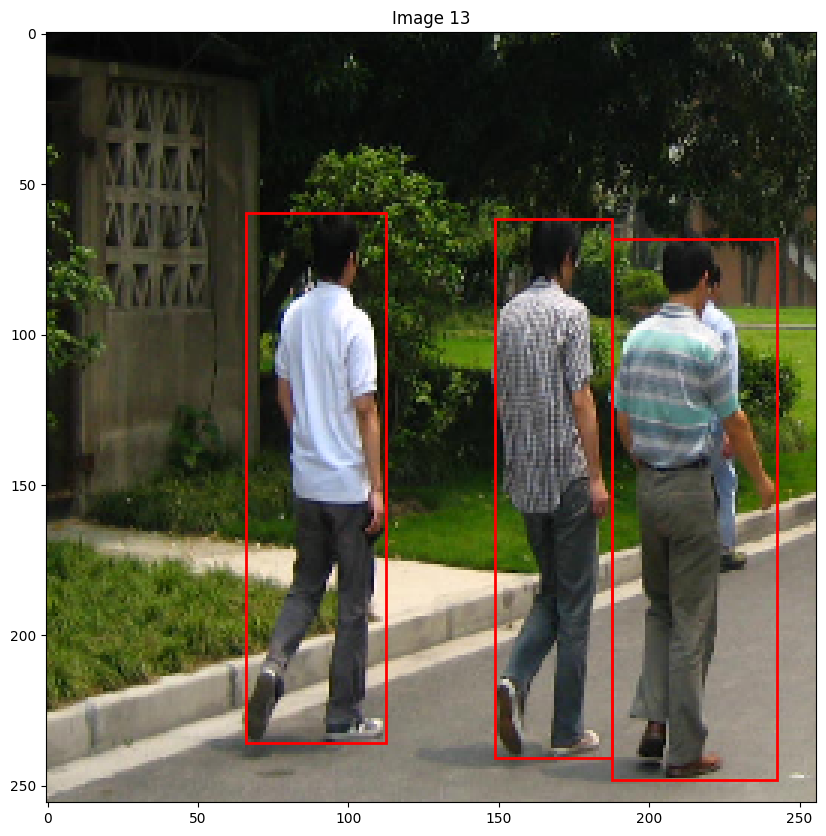

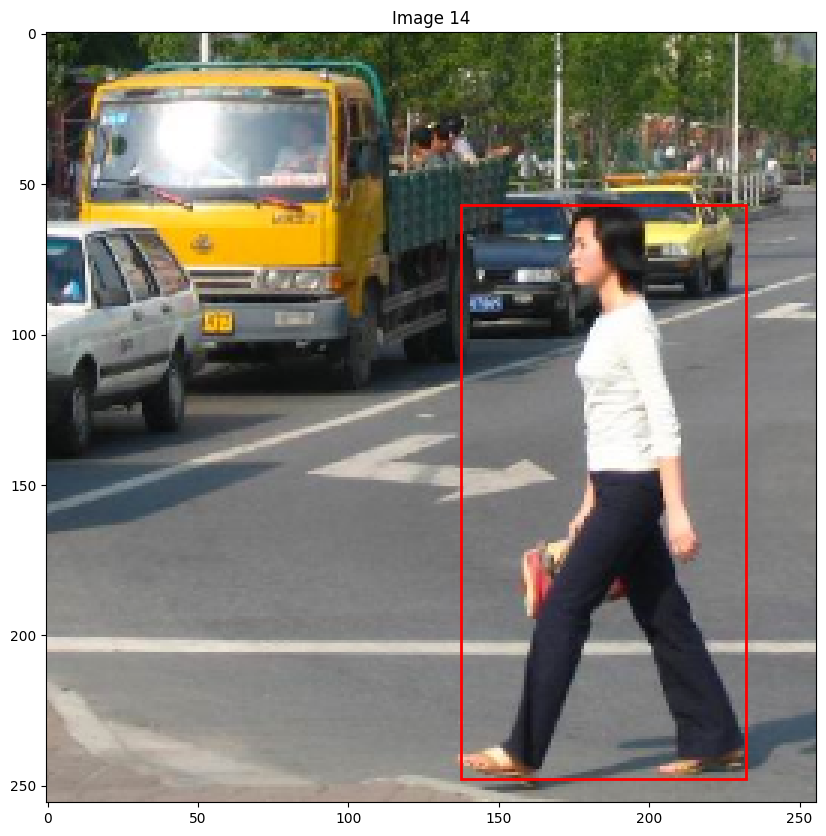

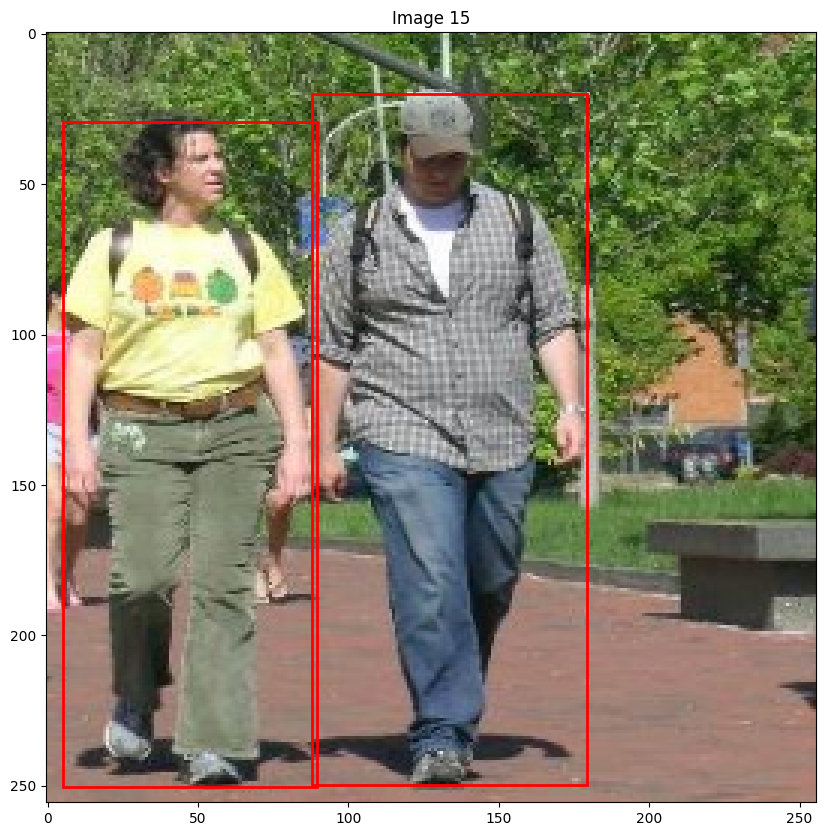

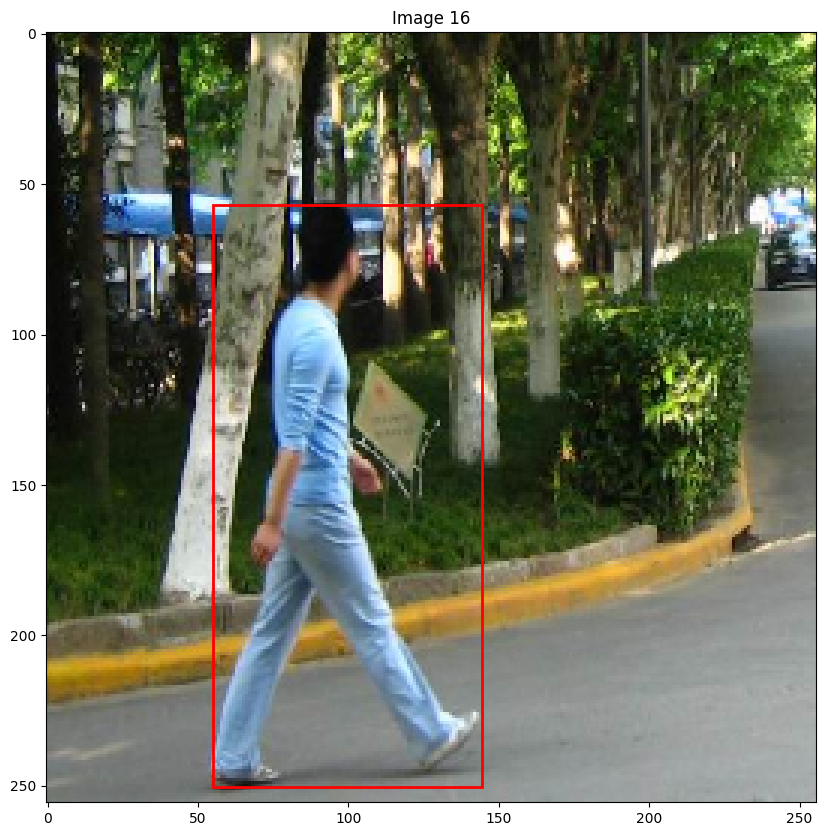

In [ ]:
# Your work here
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3, 1, 1)
    return img * std + mean


def plot_batch_predictions(imgs, outputs):
  batch_size = 16

  for i in range(batch_size):
    image = imgs[i]
    target = outputs[i]

    image = image.permute(1, 2, 0).cpu().numpy()
    target = target.cpu()
    if image.max() <= 1.0:
      image = (image * 255).astype(np.uint8)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    plt.title(f"Image {i + 1}")

    gridy, gridx = (8, 8)
    img_h, img_w = image.shape[:2]
    cell_h = img_h / gridy
    cell_w = img_w / gridx

    for gy in range(gridy):
      for gx in range(gridx):
        if target[4, gy, gx] > 0.5:
          x_offset, y_offset = target[0, gy, gx], target[1, gy, gx]
          width, height = target[2, gy, gx], target[3, gy, gx]

          x_center = (gx + x_offset) * cell_w
          y_center = (gy + y_offset) * cell_h
          width_px = width * cell_w
          height_px = height * cell_h

          x_min = x_center - (width_px / 2)
          y_min = y_center - (height_px / 2)

          rect = patches.Rectangle(
                        (x_min, y_min), width_px, height_px,
                        linewidth=2, edgecolor='red', facecolor='none'
                    )
          ax.add_patch(rect)

  plt.show()
plot_batch_predictions(denormalize(batch_X), batch_y)



## Setting up loss calculations

Objectness is essentially a binary classification task, while predicting the correct bounding box is a regression task.

Set up loss function calculations for objectness using binary cross entropy, and for bounding box localization using MSE. Create both losses in the same function for convenience, but return them separately instead of as a sum so they are easy to log later on.

Concept-wise this is pretty straightforward. However, implementation-wise, you will need to place your tensors with great care. I'll help you a bit by providing you with this template below.

```python
def custom_loss(preds, targets):
    # both preds and targets should have shape (B, 5, gy, gx)
    # where B is batch size, gy and gx are spatial feature map h and w
    ...
    return objectness_loss, localization_loss
```

_1 pt granted upon completion of loss function calculation_

In [ ]:
# Your work here
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss

def custom_loss(preds, targets):
  preds_obj = preds[:, 4, :, :]
  targets_obj = targets[:, 4, :, :]
  objectness_loss = binary_cross_entropy_with_logits(preds_obj, targets_obj)


  preds_bbox = preds[:, :4, :, :]
  targets_bbox = targets[:, :4, :, :]
  localization_loss = mse_loss(preds_bbox, targets_bbox)

  return objectness_loss, localization_loss


## Model evalution and baseline score

Create a `test_one_epoch` function that takes the model and the test dataloader as arguments. Calculate and return box IOU score (`torchvision.ops.box_iou`) in a dictionary like so:

```python
>>> metrics = test_one_epoch(model, test_dataloader)
>>> print(metrics)
{"miou": 0.005}
```

_1 pt granted upon implementing `test_one_epoch` and seeing the mean IOU score of the untrained model_

In [ ]:
# Your work here
from torchvision.ops import box_iou
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

import torch

def offset_to_corners(bboxes, grid_size=(8, 8)):
    gridy, gridx = grid_size
    device = bboxes.device

    # Create grid indices (gy, gx)
    gy, gx = torch.meshgrid(
        torch.arange(gridy, device=device),
        torch.arange(gridx, device=device),
        indexing='ij'
    )

    # Normalized grid positions [0, 1]
    grid_x = (gx + 0.5) / gridx  # Cell centers
    grid_y = (gy + 0.5) / gridy

    # Split components
    x_offset = bboxes[:, 0, :, :]
    y_offset = bboxes[:, 1, :, :]
    width = bboxes[:, 2, :, :]
    height = bboxes[:, 3, :, :]

    # Calculate absolute centers
    x_center = grid_x + x_offset / gridx
    y_center = grid_y + y_offset / gridy

    # Convert to corners
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return torch.stack([x_min, y_min, x_max, y_max], dim=1)

def test_one_epoch(model, dataloader):
  count = 0
  ious = 0.0
  metrics = {"miou": 0}
  with torch.no_grad():
    model.eval()
    for images, targets in dataloader:
      images = images.to(device)
      targets = targets.to(device)
      preds = model(images)

      targets_bboxes = targets[:, :4, :, :]
      preds_bboxes = preds[:, :4, :, :]

      iou = box_iou(offset_to_corners(preds_bboxes), offset_to_corners(targets_bboxes))
      ious += iou.sum().item()
      count += iou.numel()


  metrics["miou"] = ious / count
  return metrics


In [ ]:
metrics = test_one_epoch(model, test_dataloader)
print(metrics)

{'miou': 0.00043112364446007927}


## Model training

Train your model on the training set. Track objectness loss and localization loss during training for every 10 minibatches (a). I will leave it up to choose how to combine your losses.

At the end of every epoch, show  on both train (b) and test data (c), and plot prediction outputs of the first batch of the test dataset (d). Save the best performing model with the highest mean IOU score on test (e).

You don't need to run training for too long. I suspect <50 epochs will be sufficient.

_1 pt granted upon completion of (a) to (e)._

_Another 1 pt granted for exceeding 0.4 mean IOU on the test dataset._

In [ ]:
# Your work here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model.to(device)
batch_number = 0
for epoch in range(epochs):
  epoch_loss = 0.0
  for images, targets in train_dataloader:
    model.train()
    images = images.to(device)
    targets = targets.to(device)
    preds = model(images)
    objectness_loss, localization_loss = custom_loss(preds, targets)
    loss = objectness_loss + 5.0 * localization_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_number += 1
    if (batch_number) % 10 == 0:
      print(f"Batch {batch_number}, Objectness Loss: {objectness_loss.item()}, Localization Loss: {localization_loss.item()}")

  model.eval()
  test_iou = test_one_epoch(model, test_dataloader)
  train_iou = test_one_epoch(model, train_dataloader)
  print(f"Epoch {epoch + 1}, Train IOU: {train_iou['miou']}, Test IOU: {test_iou['miou']}")


Epoch 1, Train IOU: 0.0, Test IOU: 0.0
Batch 10, Objectness Loss: 0.40558385848999023, Localization Loss: 0.9979339838027954
Epoch 2, Train IOU: 0.0, Test IOU: 0.0
Batch 20, Objectness Loss: 0.36326920986175537, Localization Loss: 0.478386253118515
Epoch 3, Train IOU: 2.466251633891123e-08, Test IOU: 0.0
Batch 30, Objectness Loss: 0.22756320238113403, Localization Loss: 0.4088699519634247
Epoch 4, Train IOU: 1.895481967618583e-05, Test IOU: 1.0773933911335098e-05
Batch 40, Objectness Loss: 0.2031075656414032, Localization Loss: 0.3946734368801117
Epoch 5, Train IOU: 0.0009115953986166102, Test IOU: 0.0008360249308017335
Batch 50, Objectness Loss: 0.16326725482940674, Localization Loss: 0.3329526484012604
Epoch 6, Train IOU: 0.00029065368245496893, Test IOU: 0.00029778204426934667
Batch 60, Objectness Loss: 0.16711172461509705, Localization Loss: 0.303281307220459
Epoch 7, Train IOU: 8.915068346223879e-05, Test IOU: 5.410315424687583e-05
Batch 70, Objectness Loss: 0.15771734714508057, L

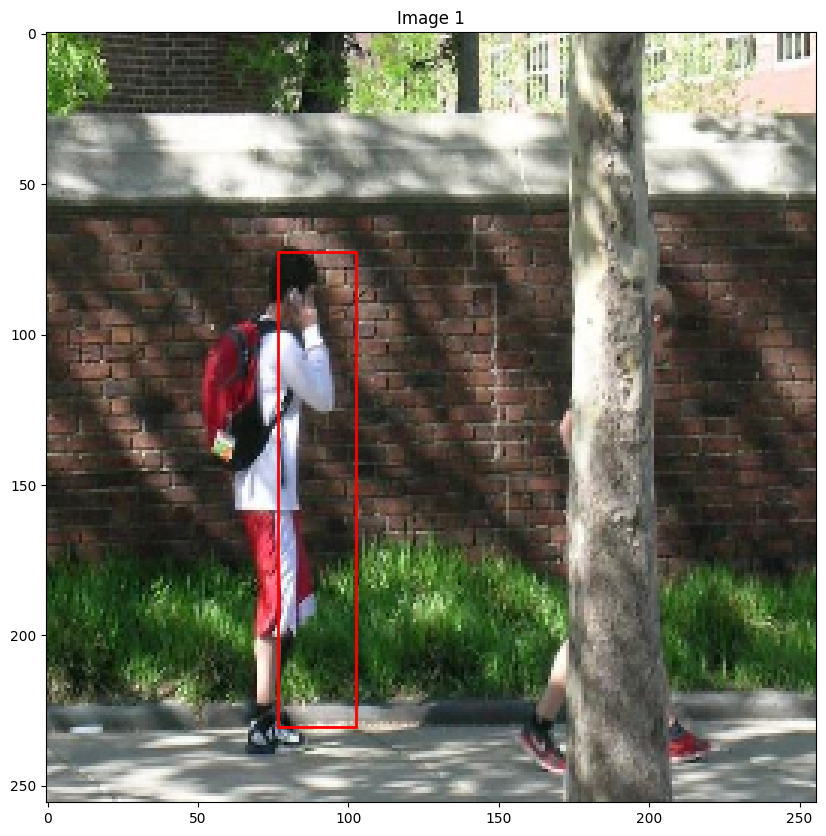

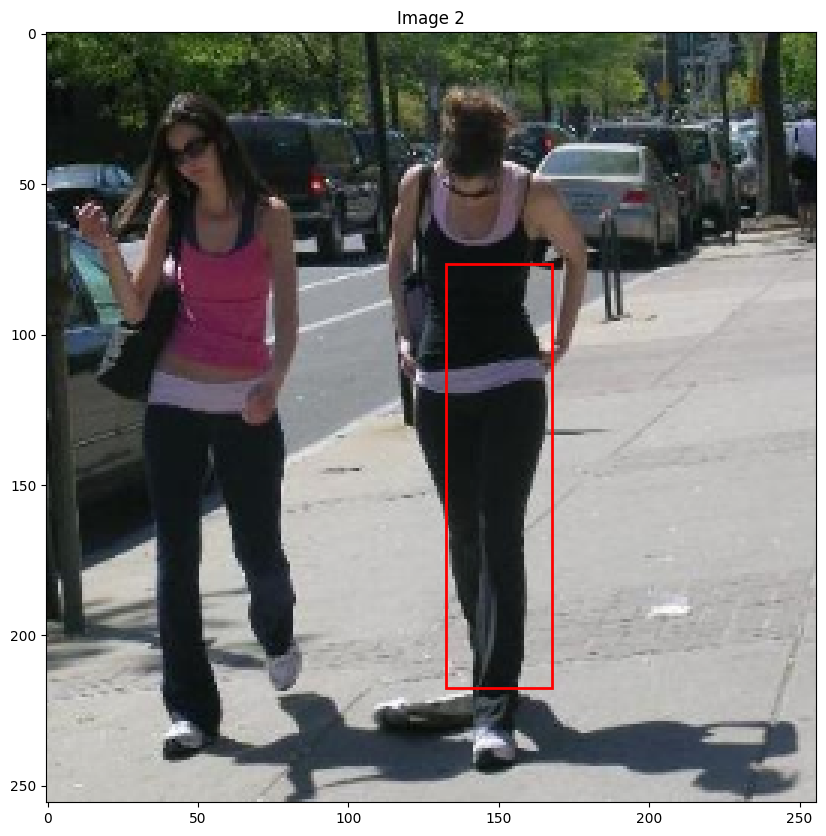

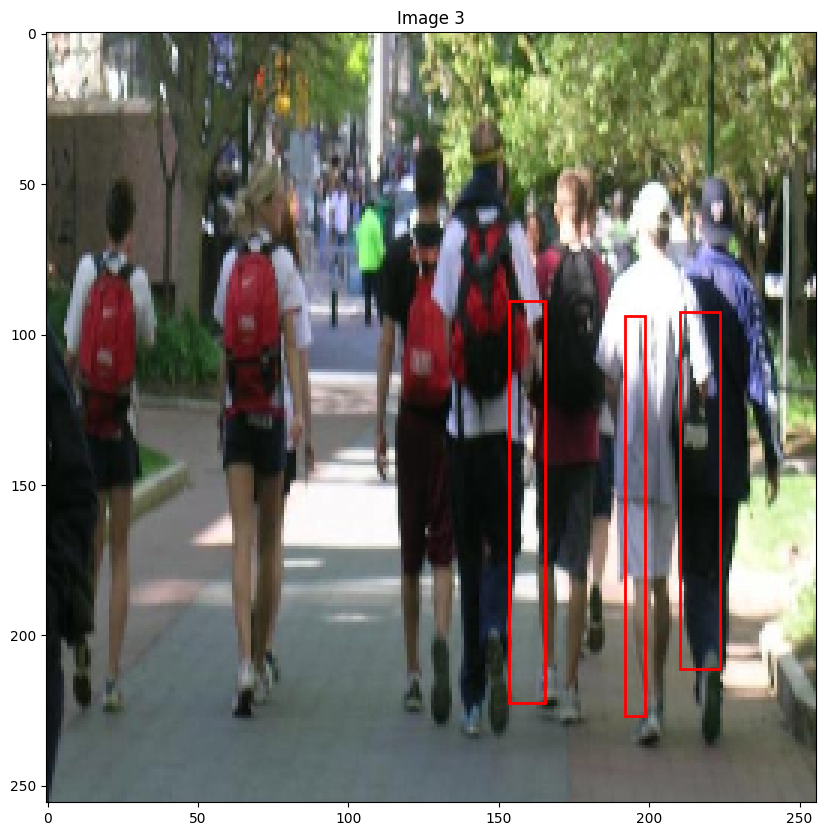

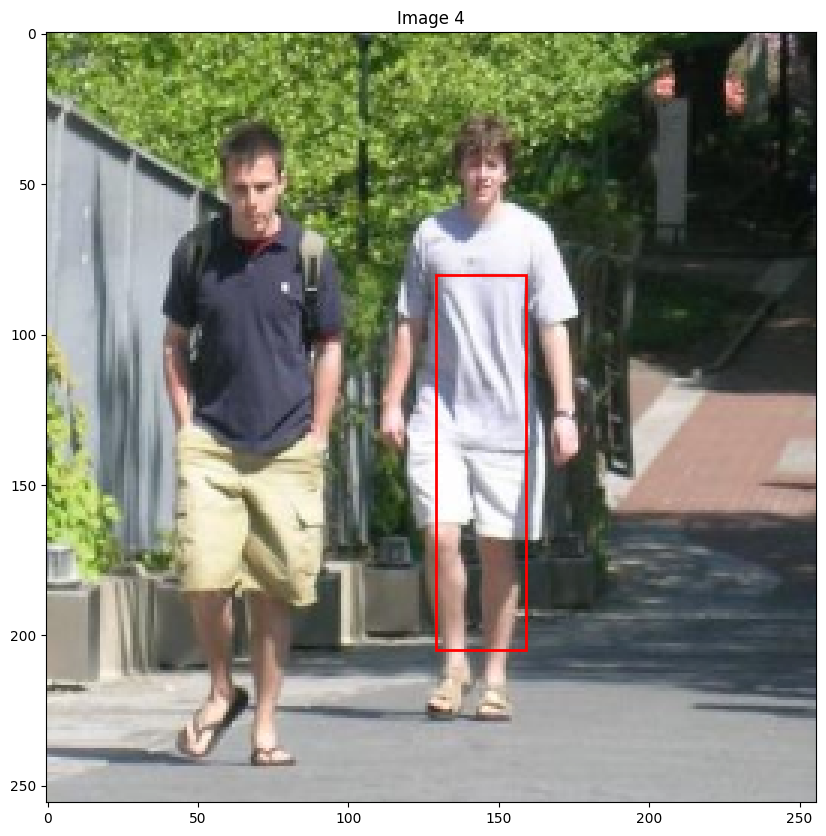

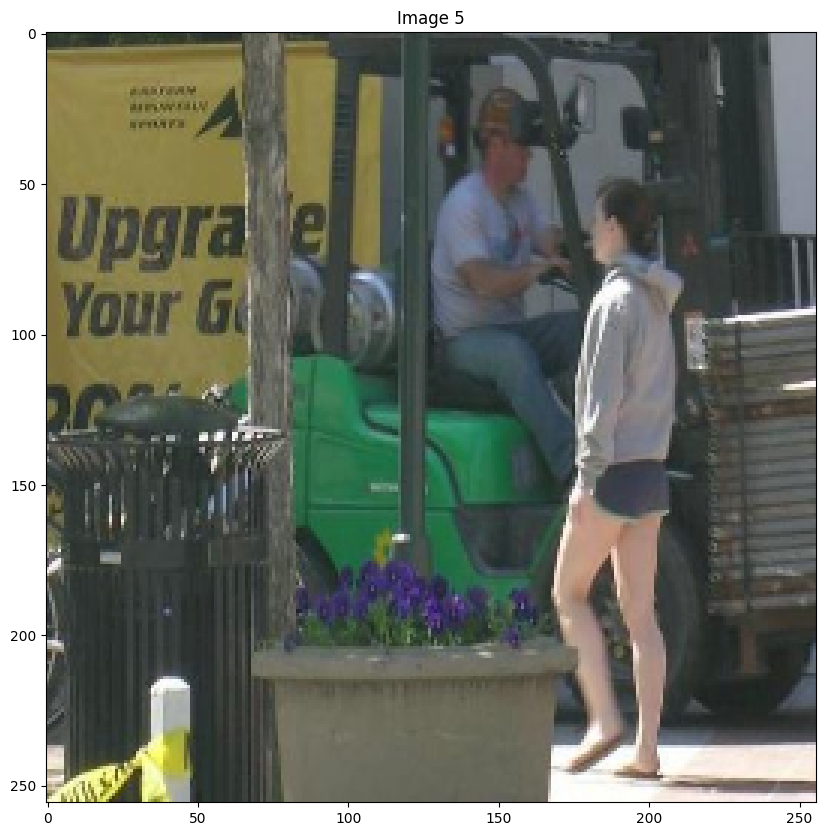

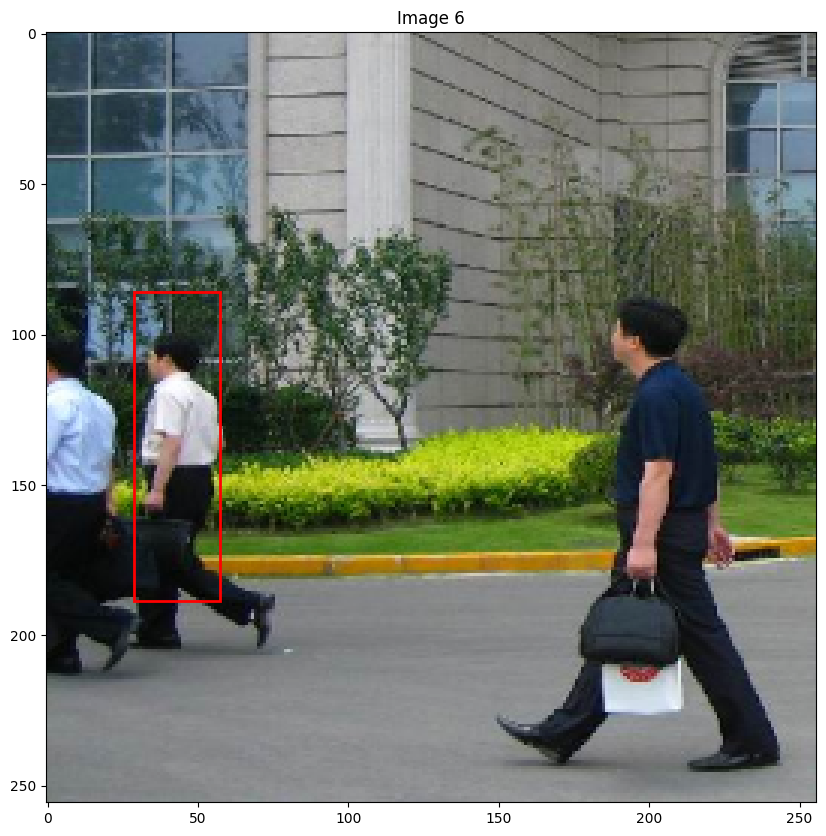

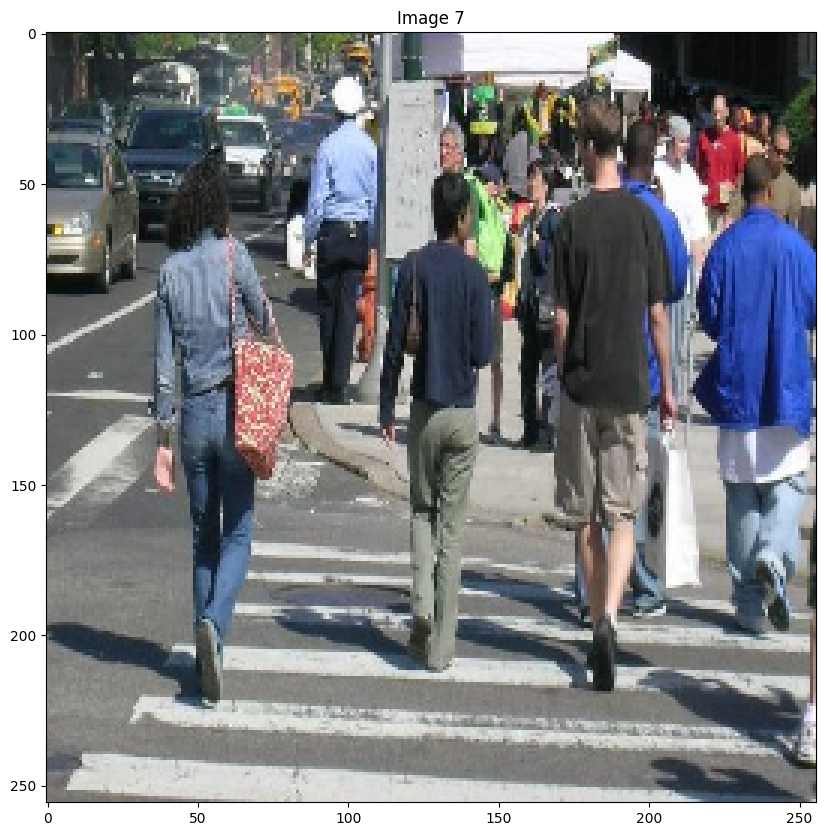

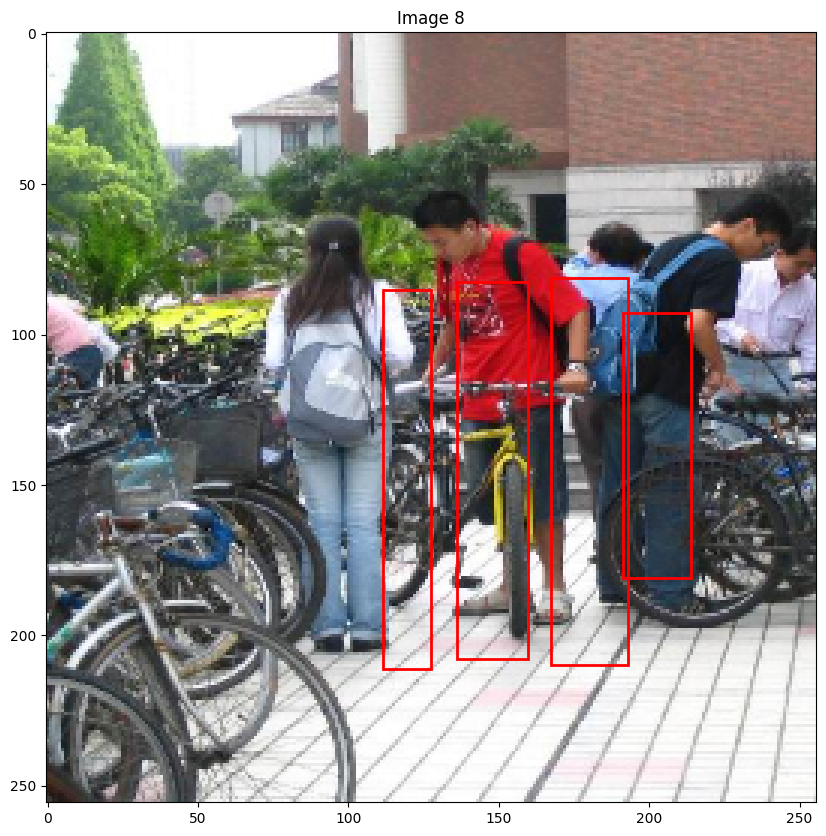

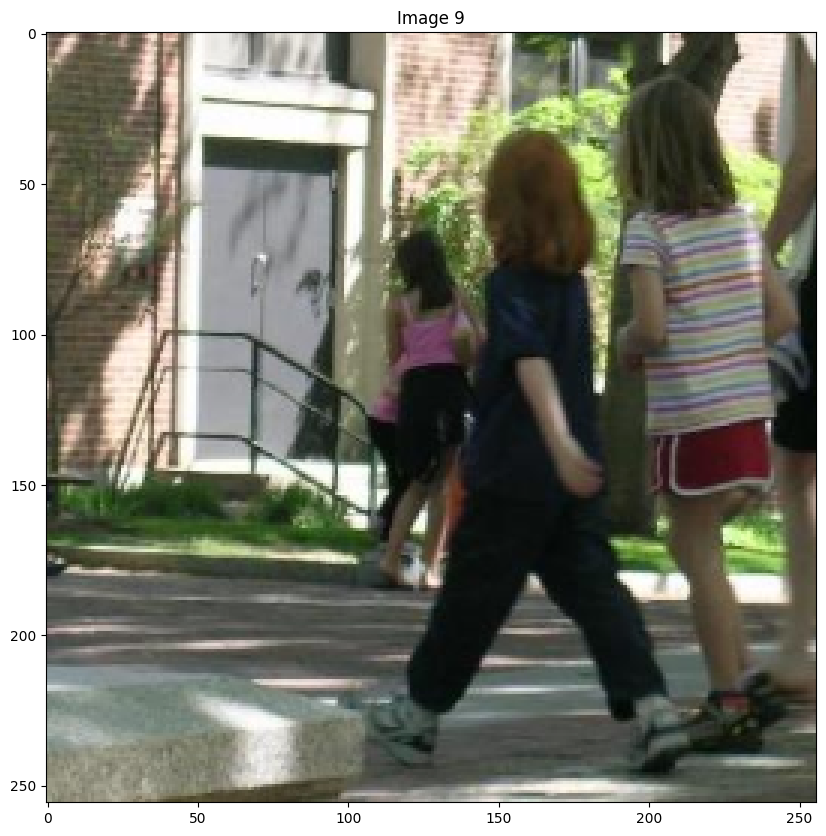

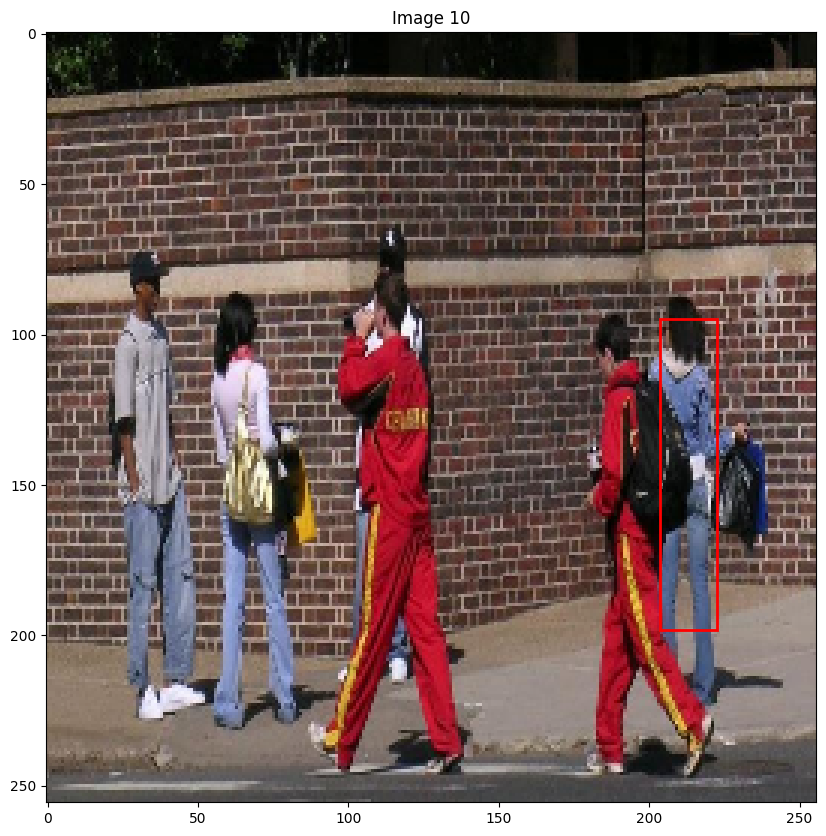

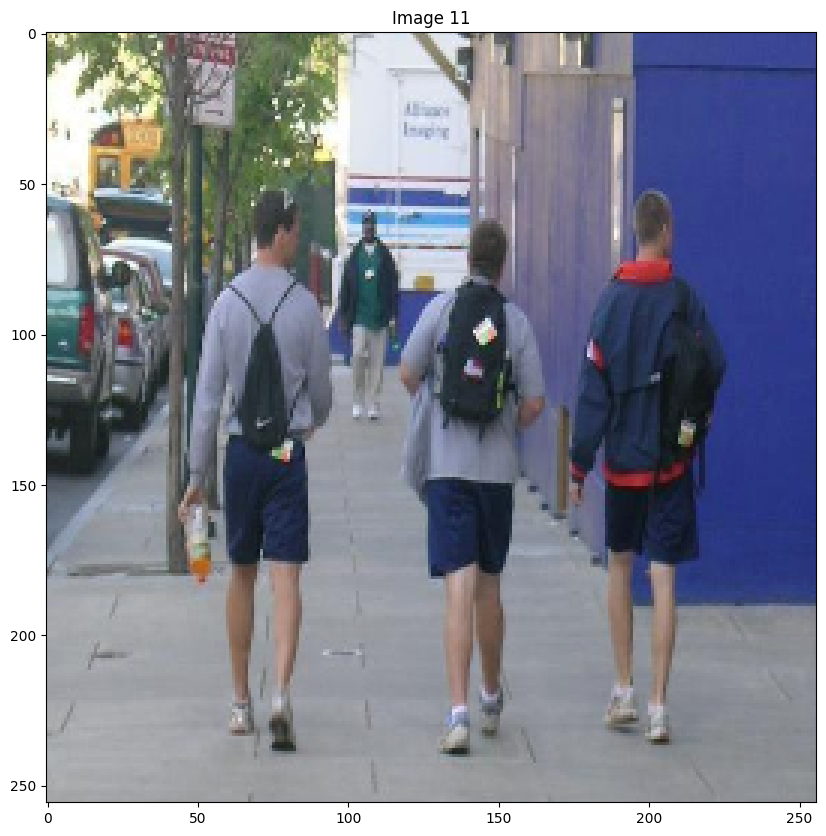

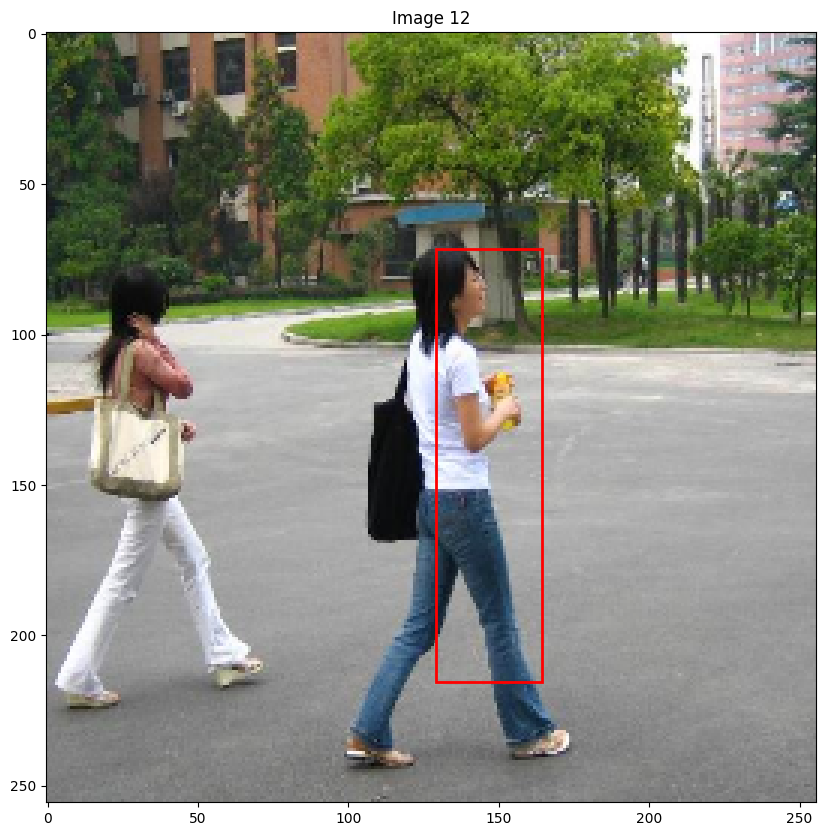

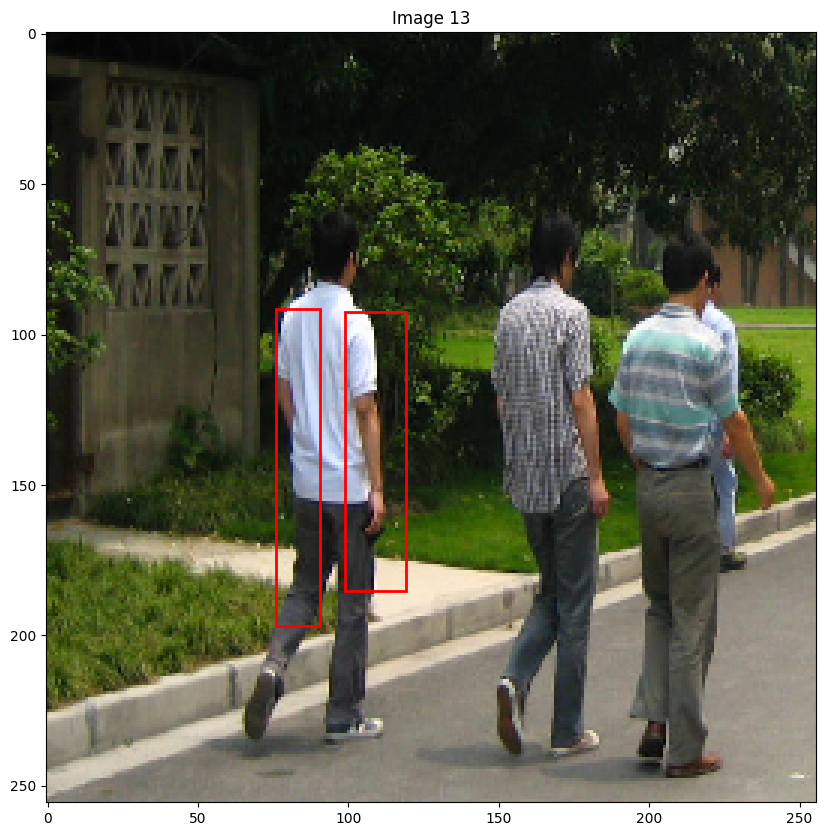

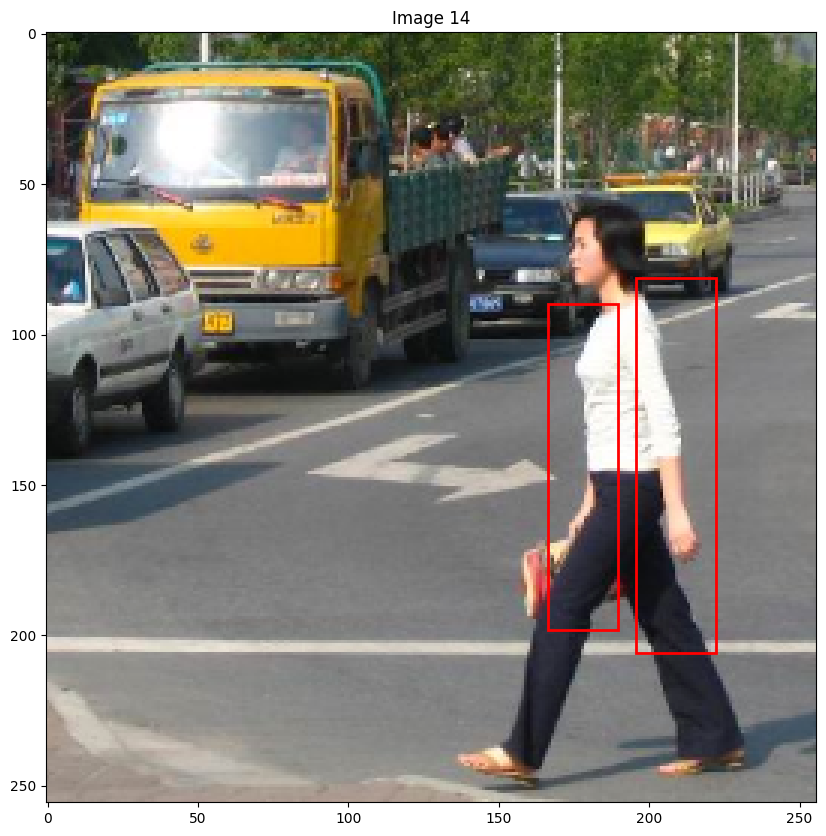

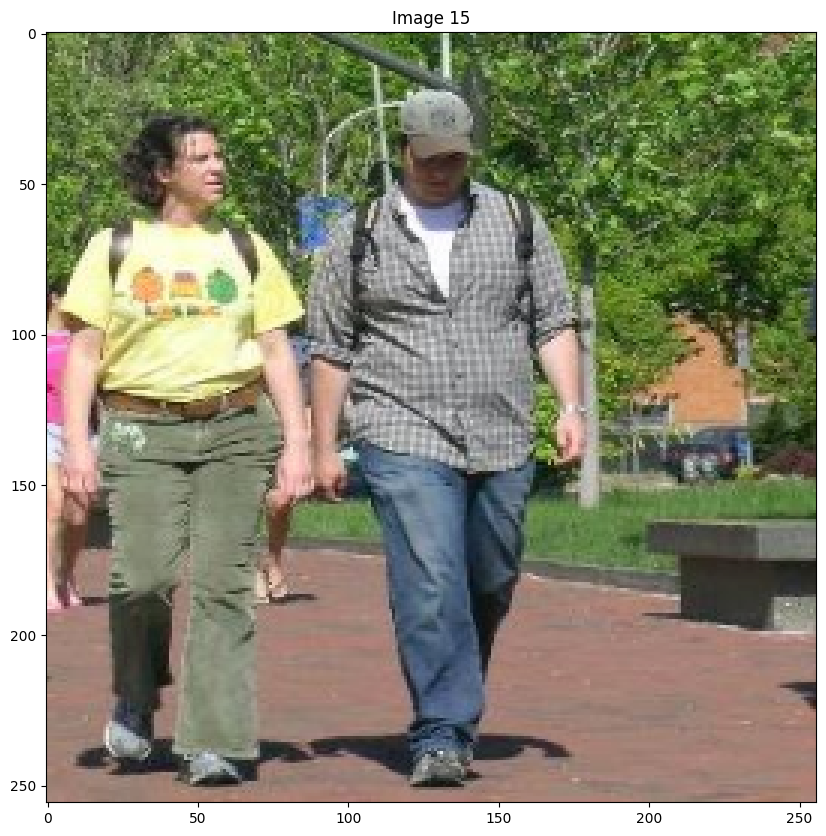

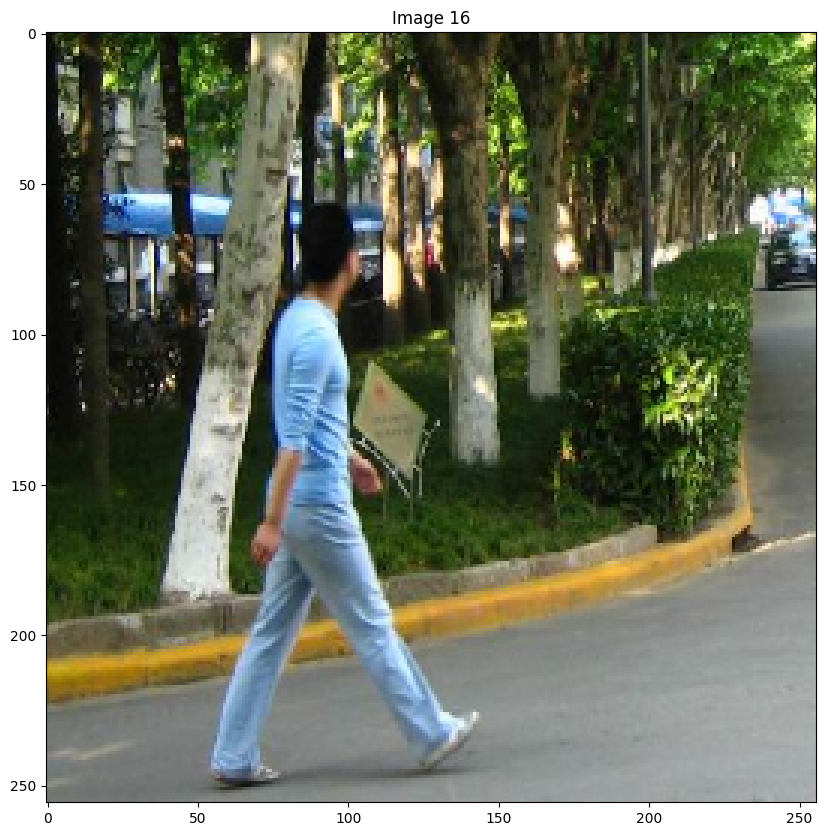

In [ ]:
with torch.no_grad():
  model.eval()
  images, targets = next(iter(test_dataloader))
  images = images.to(device)
  targets = targets.to(device)
  preds = model(images)
  plot_batch_predictions(denormalize(images), preds)

## Post training

Create a plot that contains four subplots: image with true bounding boxes, image with predicted bounding boxes, predicted objectness over spatial feature map, true objectness over spatial feature map). Repeat this plot for a few images.

_1 pt granted upon completion of the above_

In [ ]:
# Your work here

What learning task did you just perform in this notebook?

_1 pt granted upon finding the right answer_

In [ ]:
# Your answer here

This dataset is 17 years old this year. What is it called?

_1 pt granted upon finding the right answer_

In [ ]:
# Your answer here

## EX: Going off track

Name a limitation of this training setup and briefly explain your reasoning

_1 pt granted upon a satisfactory answer_

In [ ]:
# Your work here

Show me how you can modify this training setup to attain better performance.

_2 pts granted upon successfully scoring at least +0.2 mean IOU higher than the score of the best model above. Partial credit to be granted at discretion. Bonus additional +1 pt to be granted for outstanding improvements_

In [ ]:
# Your work here